In [6]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"nirjarpatel","key":"a24c399e83b88217a912c80c4d3a07f7"}'}

In [7]:
import os
import zipfile

# Create the .kaggle directory
!mkdir -p ~/.kaggle

# Move kaggle.json to the .kaggle directory
!mv kaggle.json ~/.kaggle/

# Set permissions
!chmod 600 ~/.kaggle/kaggle.json

In [8]:
!kaggle datasets download -d intelecai/car-segmentation

# Unzip the downloaded dataset
!unzip car-segmentation.zip -d /kaggle/car-segmentation

Dataset URL: https://www.kaggle.com/datasets/intelecai/car-segmentation
License(s): other
 96% 425M/442M [00:10<00:00, 46.9MB/s]
100% 442M/442M [00:10<00:00, 42.3MB/s]
Archive:  car-segmentation.zip
  inflating: /kaggle/car-segmentation/car-segmentation/classes.txt  
  inflating: /kaggle/car-segmentation/car-segmentation/images/003.png  
  inflating: /kaggle/car-segmentation/car-segmentation/images/105618339-super-purple-modern-suv-car-side-view.png  
  inflating: /kaggle/car-segmentation/car-segmentation/images/105618639-modern-pale-blue-suv-car-side-view.png  
  inflating: /kaggle/car-segmentation/car-segmentation/images/156551_preview.png  
  inflating: /kaggle/car-segmentation/car-segmentation/images/178583_Side_Profile_Web.png  
  inflating: /kaggle/car-segmentation/car-segmentation/images/1965-Shelby-Cobra-Roadster-Side-Profile.png  
  inflating: /kaggle/car-segmentation/car-segmentation/images/2008-Morgan-Life-Car-Side-Speed-1024x768.png  
  inflating: /kaggle/car-segmentation/c

In [9]:
!pip install albumentations==0.4.6
!pip install pytorch_lightning
!pip install mlflow
!pip install mlflow-pytorch
import cv2
import PIL
import matplotlib.pyplot as plt
from torch.utils.data import Dataset , DataLoader
import os
import torch
import numpy as np
import pytorch_lightning as pl
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torchvision.transforms import transforms
import mlflow
import mlflow.pytorch
from pytorch_lightning.loggers import MLFlowLogger
from pytorch_lightning.callbacks import ModelCheckpoint
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'using {device}')

ERROR: Could not find a version that satisfies the requirement mlflow-pytorch (from versions: none)
ERROR: No matching distribution found for mlflow-pytorch
using cuda


In [10]:
ROOT_DIR =  '/kaggle/car-segmentation/car-segmentation'
BATCH_SIZE = 32

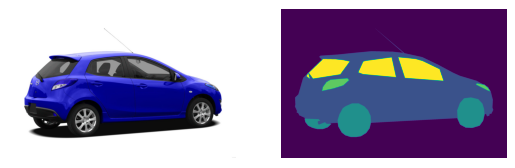

In [16]:
img = cv2.imread(f"{ROOT_DIR}/images/im18.png")
mask = cv2.imread(f"{ROOT_DIR}//masks/im18.png")
plt.subplot(1,2,1)
plt.imshow(img)
plt.axis(False)
plt.subplot(1,2,2)
plt.imshow(mask[:,:,0])
plt.axis(False)
plt.show()

In [31]:
class CarData(Dataset):
    def __init__(self,image_dir , mask_dir,size=(256,256)):
      super().__init__()
      self.image_dir = image_dir
      self.mask_dir = mask_dir
      self.image_list = os.listdir(self.image_dir)
      self.mask_list = os.listdir(self.mask_dir)
      # self.transform_img = transforms.Compose([
      #     transforms.ToTensor(),
      #     transforms.Resize(size,antialias=True)
      # ])
      self.transform = transform
      self.size = size

    def __getitem__(self,index):
      img = cv2.imread(self.image_dir+self.image_list[index])
      mask = cv2.imread(self.mask_dir+self.mask_list[index])[:,:,0]
      mask = torch.from_numpy(cv2.resize(mask,self.size)).squeeze().to(torch.long)
      # img = self.transform_img(img)
      if self.transform:
        transformed = self.transform(image=img,mask=mask.numpy())
        img = transformed['image']
        mask = transformed['mask']
        # img , mask = self.transform(image=img,mask=mask)
        # img = img.permute(2,0,1)
      return img , mask

    def __len__(self):
      return len(self.image_list)

transform = A.Compose([
    A.Resize(height=256, width=256),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.ShiftScaleRotate(scale_limit=0.1, rotate_limit=15, shift_limit=0.1, p=0.5, border_mode=cv2.BORDER_CONSTANT),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
  ])
car_data = CarData(f"{ROOT_DIR}/images/",f"{ROOT_DIR}/masks/")
car_dataloader = DataLoader(car_data,batch_size=BATCH_SIZE,shuffle=True)
mlflow_log = MLFlowLogger(experiment_name='Car_Segmentation',tracking_uri='https://mlflow.lewagon.ai/')

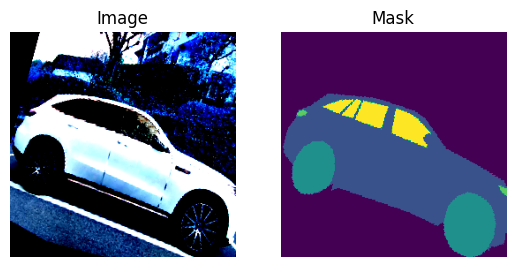

In [15]:
for i in car_dataloader:
    img , mask = i
    plt.subplot(1,2,1)
    plt.imshow(img[0].permute(1,2,0))
    plt.title('Image')
    plt.axis(False)
    plt.subplot(1,2,2)
    plt.imshow(mask[0])
    plt.title('Mask')
    plt.axis(False)
    plt.show()
    break


In [35]:
import torch.nn as nn
class convo_block(nn.Module):
    def __init__(self, in_channels,out_channels):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv2d(in_channels,out_channels,kernel_size=3,padding=1,bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
    def forward(self,input_tensor):
        output_tensor = self.model(input_tensor)
        return output_tensor
class up_block(nn.Module):
    def __init__(self,in_channels,out_channels) -> None:
        super().__init__()
        self.up = nn.ConvTranspose2d(in_channels,out_channels,kernel_size=4,padding=1,stride=2)
    def forward(self,input_tensor):
        output_tensor = self.up(input_tensor)
        return output_tensor

class UNET(nn.Module):
    def __init__(self,input_channels,output_channels):
        super().__init__()
        self.pool_layer = nn.MaxPool2d(kernel_size=2,stride=2)
        self.e1 = convo_block(input_channels,16)
        self.e2 = convo_block(16,32)
        self.e3 = convo_block(32,64)
        self.e4 = convo_block(64,128)
        self.e5 = convo_block(128,256)

        self.b = convo_block(256,256)
        self.u1 = up_block(256,256)
        self.d1 = convo_block(256*2,128)
        self.u2 = up_block(128,128)
        self.d2 = convo_block(128*2,64)
        self.u3 = up_block(64,64)
        self.d3 = convo_block(64*2,32)
        self.u4 = up_block(32,32)
        self.d4 = convo_block(32*2,16)
        self.u5 = up_block(16,16)
        self.d5 = convo_block(16*2,16)

        self.out = nn.Conv2d(16,output_channels,kernel_size=3,padding=1)

    def forward(self,input_tensor):
        x = input_tensor
        s1 = self.e1(input_tensor)
        x = self.pool_layer(s1)
        s2 = self.e2(x)
        x = self.pool_layer(s2)
        s3 = self.e3(x)
        x = self.pool_layer(s3)
        s4 = self.e4(x)
        x = self.pool_layer(s4)
        s5 = self.e5(x)
        x = self.pool_layer(s5)
        x = self.b(x)
        x = self.u1(x)
        x = torch.cat((s5,x),dim=1)
        x = self.d1(x)
        x = self.u2(x)
        x = torch.cat((s4,x),dim=1)
        x = self.d2(x)
        x = self.u3(x)
        x = torch.cat((s3,x),dim=1)
        x = self.d3(x)
        x = self.u4(x)
        x = torch.cat((s2,x),dim=1)
        x = self.d4(x)
        x = self.u5(x)
        x = torch.cat((s1,x),dim=1)
        x = self.d5(x)
        output_tensor = self.out(x)
        return output_tensor

In [52]:
import torch.nn as nn
class convo_block(nn.Module):
    def __init__(self, in_channels,out_channels):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv2d(in_channels,out_channels,kernel_size=3,padding=1,bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
    def forward(self,input_tensor):
        output_tensor = self.model(input_tensor)
        return output_tensor
class up_block(nn.Module):
    def __init__(self,in_channels,out_channels) -> None:
        super().__init__()
        self.up = nn.ConvTranspose2d(in_channels,out_channels,kernel_size=4,padding=1,stride=2)
    def forward(self,input_tensor):
        output_tensor = self.up(input_tensor)
        return output_tensor

class UNET(pl.LightningModule):
    def __init__(self,input_channels,output_channels, lr=1e-3):
        super().__init__()
        self.pool_layer = nn.MaxPool2d(kernel_size=2,stride=2)
        self.e1 = convo_block(input_channels,16)
        self.e2 = convo_block(16,32)
        self.e3 = convo_block(32,64)
        self.e4 = convo_block(64,128)
        self.e5 = convo_block(128,256)

        self.b = convo_block(256,256)
        self.u1 = up_block(256,256)
        self.d1 = convo_block(256*2,128)
        self.u2 = up_block(128,128)
        self.d2 = convo_block(128*2,64)
        self.u3 = up_block(64,64)
        self.d3 = convo_block(64*2,32)
        self.u4 = up_block(32,32)
        self.d4 = convo_block(32*2,16)
        self.u5 = up_block(16,16)
        self.d5 = convo_block(16*2,16)

        self.out = nn.Conv2d(16,output_channels,kernel_size=3,padding=1)
        self.lr = lr
    def forward(self,input_tensor):
        x = input_tensor
        s1 = self.e1(input_tensor)
        x = self.pool_layer(s1)
        s2 = self.e2(x)
        x = self.pool_layer(s2)
        s3 = self.e3(x)
        x = self.pool_layer(s3)
        s4 = self.e4(x)
        x = self.pool_layer(s4)
        s5 = self.e5(x)
        x = self.pool_layer(s5)
        x = self.b(x)
        x = self.u1(x)
        x = torch.cat((s5,x),dim=1)
        x = self.d1(x)
        x = self.u2(x)
        x = torch.cat((s4,x),dim=1)
        x = self.d2(x)
        x = self.u3(x)
        x = torch.cat((s3,x),dim=1)
        x = self.d3(x)
        x = self.u4(x)
        x = torch.cat((s2,x),dim=1)
        x = self.d4(x)
        x = self.u5(x)
        x = torch.cat((s1,x),dim=1)
        x = self.d5(x)
        output_tensor = self.out(x)
        return output_tensor
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
        return optimizer
    def training_step(self, batch, batch_index):
        inputs, masks = batch
        pred = self(inputs)
        loss_func = nn.CrossEntropyLoss()
        loss = loss_func(pred, masks)
        self.log('train_loss', loss)
        return loss


In [53]:
# import torch
# import torch.nn as nn
# import torch.nn.functional as F

# class model_0(nn.Module):
#     def __init__(self, input_channels, num_classes):
#         super(model_0, self).__init__()

#         # Define convolutional layers
#         self.conv1 = nn.Conv2d(input_channels, 64, kernel_size=3, padding=1)
#         self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
#         self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)

#         # Define batch normalization layers
#         self.bn1 = nn.BatchNorm2d(64)
#         self.bn2 = nn.BatchNorm2d(128)
#         self.bn3 = nn.BatchNorm2d(256)

#         # Define upsampling layers
#         self.upsample1 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
#         self.upsample2 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
#         self.upsample3 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

#         # Final convolution to get the desired number of output classes
#         self.final_conv = nn.Conv2d(256, num_classes, kernel_size=1)

#     def forward(self, x):
#         # Apply first convolution and batch normalization
#         x = F.relu(self.bn1(self.conv1(x)))

#         # Apply second convolution and batch normalization
#         x = F.relu(self.bn2(self.conv2(x)))

#         # Apply third convolution and batch normalization
#         x = F.relu(self.bn3(self.conv3(x)))

#         # Upsample the feature maps
#         x = self.upsample1(x)
#         x = self.upsample2(x)
#         x = self.upsample3(x)

#         # Apply final convolution
#         x = self.final_conv(x)

#         return x


In [54]:
checkpt = ModelCheckpoint(
    monitor='train_loss',
    dirpath='checkpoints',
    filename='{epoch:02d}-{train_loss:.2f}',
    save_top_k=5,
    mode='min',
    verbose=True
)
model = UNET(3,5).to(device)
# criterion = nn.CrossEntropyLoss()
# optim = torch.optim.Adam(model.parameters(),lr=1e-3)
# # optim = torch.optim.SGD(params=model.parameters(),lr=0.1)
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optim,factor=0.1,patience=1,verbose=True)

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


In [58]:
trainer = pl.Trainer(
    max_epochs=100,
    accelerator='gpu' if torch.cuda.is_available() else 'cpu', # Use accelerator instead of gpus
    devices=1 if torch.cuda.is_available() else 0, # Specify number of devices
    logger=mlflow_log,
    callbacks=[checkpt]
)
trainer.fit(model,car_dataloader)


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name       | Type        | Params | Mode 
----------------------------------------------------
0  | pool_layer | MaxPool2d   | 0      | train
1  | e1         | convo_block | 464    | train
2  | e2         | convo_block | 4.7 K  | train
3  | e3         | convo_block | 18.6 K | train
4  | e4         | convo_block | 74.0 K | train
5  | e5         | convo_block | 295 K  | train
6  | b          | convo_block | 590 K  | train
7  | u1         | up_block    | 1.0 M  | train
8  | d1         | convo_block | 590 K  | train
9  | u2         | up_block    | 262 K  | train
10 | d2         | convo_block | 147 K  | train
11 | u3

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 7: 'train_loss' was not in top 5
INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 14: 'train_loss' was not in top 5
INFO:pytorch_lightning.utilities.rank_zero:Epoch 2, global step 21: 'train_loss' was not in top 5
INFO:pytorch_lightning.utilities.rank_zero:Epoch 3, global step 28: 'train_loss' was not in top 5
INFO:pytorch_lightning.utilities.rank_zero:Epoch 4, global step 35: 'train_loss' was not in top 5
INFO:pytorch_lightning.utilities.rank_zero:Epoch 5, global step 42: 'train_loss' reached 0.10118 (best 0.10044), saving model to '/content/checkpoints/epoch=05-train_loss=0.10.ckpt' as top 5
INFO:pytorch_lightning.utilities.rank_zero:Epoch 6, global step 49: 'train_loss' reached 0.09431 (best 0.09431), saving model to '/content/checkpoints/epoch=06-train_loss=0.09.ckpt' as top 5
INFO:pytorch_lightning.utilities.rank_zero:Epoch 7, global step 56: 'train_loss' reached 0.10410 (best 0.09431), saving model to 

In [60]:
model.to(device)

UNET(
  (pool_layer): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (e1): convo_block(
    (model): Sequential(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
  )
  (e2): convo_block(
    (model): Sequential(
      (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
  )
  (e3): convo_block(
    (model): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
  )
  (e4): convo_block(
    (model): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1)

In [ ]:
# import sys
# def train(model,optim,criterion,dataloader,epochs):
#     for epoch in range(1,epochs+1):
#         losses = []
#         for idx,(img,mask) in enumerate(dataloader):
#             img = img.to(device)
#             mask = mask.to(device)
#             optim.zero_grad()
#             out = model(img)
#             loss = criterion(out,mask)
#             loss.backward()
#             optim.step()
#             losses.append(loss.item())
#             log('train_loss', loss)
#             sys.stdout.write(f"\r EPOCH [{epoch}/{epochs}] IDX [{idx+1}/{len(dataloader)}] batch_loss={loss.item():.5f} , running_loss={(sum(losses)/len(losses)):.5f}")
#         mean_loss = sum(losses)/len(losses)
#         scheduler.step(mean_loss)
#         print()

In [21]:
# train(model,optim,criterion,car_dataloader,epochs=100)

 EPOCH [1/10] IDX [7/7] batch_loss=1.19524 , running_loss=1.32805
 EPOCH [2/10] IDX [7/7] batch_loss=0.82712 , running_loss=0.91983
 EPOCH [3/10] IDX [7/7] batch_loss=0.63093 , running_loss=0.70464
 EPOCH [4/10] IDX [7/7] batch_loss=0.51769 , running_loss=0.56713
 EPOCH [5/10] IDX [7/7] batch_loss=0.49544 , running_loss=0.48990
 EPOCH [6/10] IDX [7/7] batch_loss=0.45170 , running_loss=0.46807
 EPOCH [7/10] IDX [7/7] batch_loss=0.43657 , running_loss=0.43332
 EPOCH [8/10] IDX [7/7] batch_loss=0.45461 , running_loss=0.42494
 EPOCH [9/10] IDX [7/7] batch_loss=0.33476 , running_loss=0.38761
 EPOCH [10/10] IDX [7/7] batch_loss=0.35354 , running_loss=0.38271


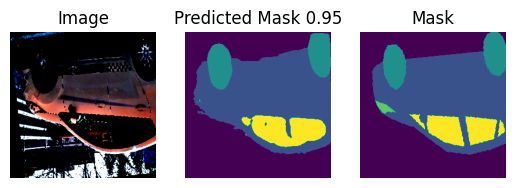

In [61]:
import torch.nn.functional as F
def dice_coef(img, img2):
        if img.shape != img2.shape:
            raise ValueError("Shape mismatch.")
        else:

            lenIntersection=0

            for i in range(img.shape[0]):
                for j in range(img.shape[1]):
                    if ( np.array_equal(img[i][j],img2[i][j]) ):
                        lenIntersection+=1

            lenimg=img.shape[0]*img.shape[1]
            lenimg2=img2.shape[0]*img2.shape[1]
            value = (2. * lenIntersection  / (lenimg + lenimg2))
        return value
for i in car_dataloader:
    img , _ = i
    plt.subplot(1,3,1)
    plt.imshow(img[0].permute(1,2,0))
    plt.title('Image')
    plt.axis(False)
    plt.subplot(1,3,2)
    img = img.to(device)
    with torch.no_grad():
        out = model(img)
    probs = F.softmax(out,dim=1)
    out = torch.argmax(probs, dim=1,keepdim=True)
    mask = out.detach().cpu().squeeze()
    dc = dice_coef(_[0],mask[0])
    plt.imshow(mask[0])
    plt.title(f'Predicted Mask {dc:.2f}')
    plt.axis(False)
    plt.subplot(1,3,3)
    plt.imshow(_[0])
    plt.title('Mask')
    plt.axis(False)
    plt.show()
    break

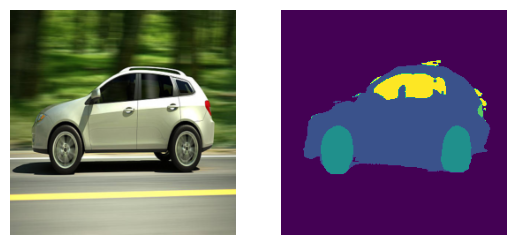

In [62]:
import requests
from PIL import Image
import numpy as np
from io import BytesIO
image_url = "https://media.istockphoto.com/id/174828866/photo/suv-car-driving-forest-road-clipping-path-included.jpg?s=612x612&w=0&k=20&c=3gHYiB27gRsl_-A8nwrhv-4SfIZkFKHaslZi0xm7SEY="
response = requests.get(image_url)
img = Image.open(BytesIO(response.content))
img_array = np.array(img)
transform_img = transforms.Compose([
          transforms.ToTensor(),
          transforms.Resize((256,256),antialias=True)
      ])
tensor = transform_img(img_array)
with torch.no_grad():
        out = model(tensor.unsqueeze(dim=0).to(device))
probs = F.softmax(out,dim=1)
out = torch.argmax(probs, dim=1,keepdim=True)
mask = out.detach().cpu().squeeze()

plt.subplot(1,2,1)
plt.imshow(tensor.permute(1,2,0).detach().cpu().numpy())
plt.axis(False)


plt.subplot(1,2,2)
plt.imshow(mask)
plt.axis(False)

plt.show()